# Exploring the coral data

In [2]:
import geopandas as gpd
# gml_file_coral_reefs = "./KystOgFiskeri_50_Trondelag_25832_Korallrev_GML.gml"
gml_file_coral_reefs = "./raw_data/KystOgFiskeri_50_Trondelag_25833_Korallrev_GML.gml"

coral_data = gpd.read_file(gml_file_coral_reefs)

print(coral_data.columns)

Index(['gml_id', 'lokalId', 'navnerom', 'verifiseringsdato', 'produkt',
       'versjon', 'målemetode', 'nøyaktighet', 'medium', 'opphav',
       'minimumsdybde', 'maksimumsdybde', 'naturtype', 'naturtypeNavn',
       'kildeNavn', 'observasjonsMetode', 'observasjonsSted',
       'observasjonsSlutt', 'lengdegrad', 'breddegrad', 'geometry'],
      dtype='object')


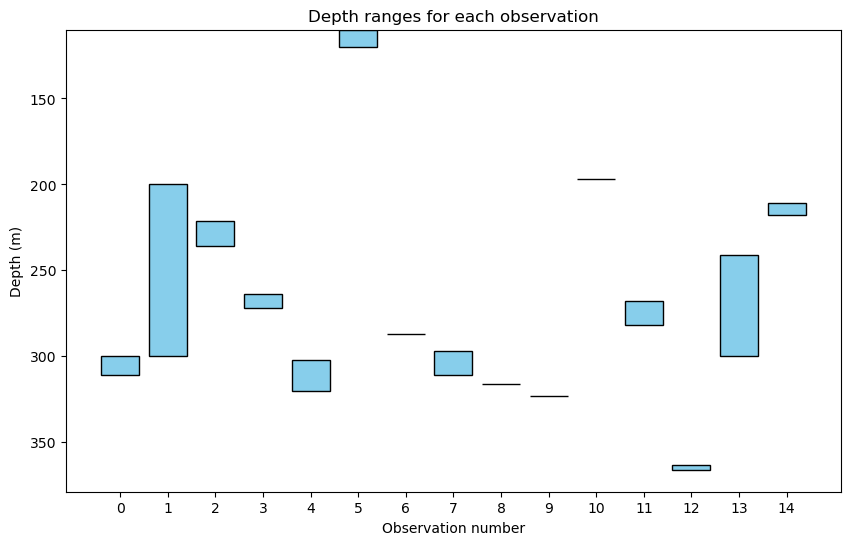

Number of coral data entries without depth data: 89 out of 104


In [3]:
import matplotlib.pyplot as plt
import numpy as np

coral_data_drop_depth_data = coral_data[(coral_data['minimumsdybde'] != 0) & (coral_data['maksimumsdybde'] != 0)]

observation_numbers = np.arange(0, len(coral_data_drop_depth_data))
min_depths = coral_data_drop_depth_data['minimumsdybde'].values  
max_depths = coral_data_drop_depth_data['maksimumsdybde'].values 
depth_ranges = max_depths - min_depths

plt.figure(figsize=(10, 6))
plt.bar(observation_numbers, depth_ranges, bottom=min_depths, color='skyblue', edgecolor='black')

plt.xlabel("Observation number")
plt.ylabel("Depth (m)")
plt.title("Depth ranges for each observation")
plt.xticks(observation_numbers)
plt.gca().invert_yaxis()  
plt.show()

missing_depth_data_count = coral_data[(coral_data['minimumsdybde'] == 0) | (coral_data['maksimumsdybde'] == 0)].shape[0]
print(f"Number of coral data entries without depth data: {missing_depth_data_count} out of {len(coral_data)}")

# Exploring SINMOD data

- PCA

# Exploring SINMOD and Coral data

- Histograms of features at coral data locations (and randomly sampled histograms)
- PLS


In [21]:
from netCDF4 import Dataset

# Importing SINMOD data
filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/gin/spinup/run2/PhysStates.nc'

PhysStates_data = Dataset(filename_PhysStates, 'r')

filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/nor4km_2019/2019/PhysStates.nc'

nor4km_PhysStates_data = Dataset(filename_PhysStates, 'r')

filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'

midnor_PhysStates_data = Dataset(filename_PhysStates, 'r')

# Import coral data
coral_data = gpd.read_file('./processed_data/coral_data_trondelag_processed.parquet')

nor4km_coral_data = gpd.read_file('./processed_data/nor4km_coral_data_trondelag_processed.parquet')

midnor_coral_data = gpd.read_file('./processed_data/midnor_coral_data_trondelag_processed.parquet')

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting temperature
temperature_var = PhysStates_data.variables['temperature']
zc = PhysStates_data.variables['LayerDepths'][:]
cumulative_depth = np.cumsum(zc, axis=0)
depth = PhysStates_data.variables['depth'][:]

depth_layer_250 = np.searchsorted(cumulative_depth, 250)

depth_layer_250


np.int64(12)

In [61]:
midnor_PhysStates_data.variables['temperature'][0,0].shape

(555, 950)

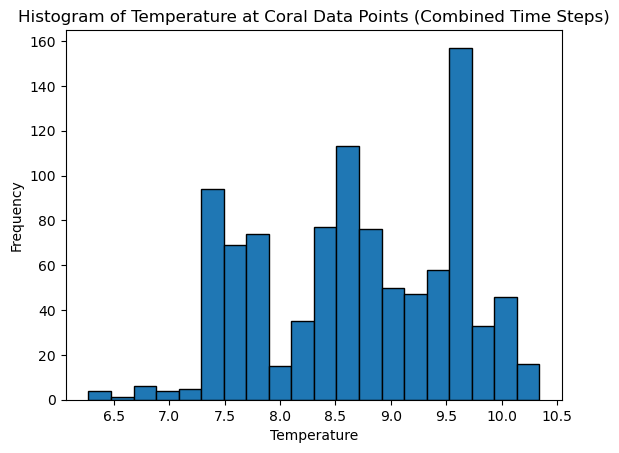

Number of valid coordinates: 98.0 out of 104


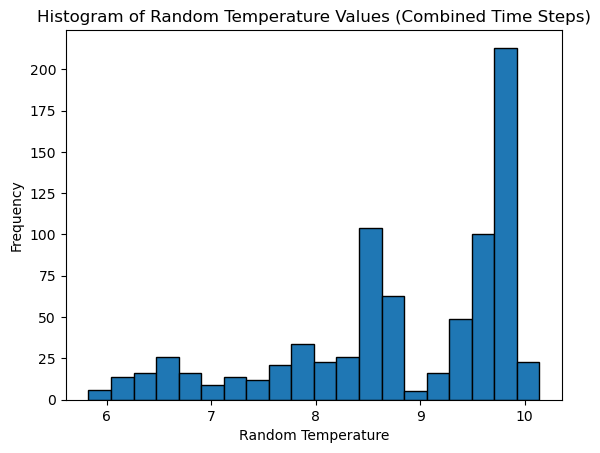

Number of valid random coordinates: 79.0 out of 104


In [72]:
# Now plot histogram of temperature values at coral data points
import random

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, generate_random=False):

    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    # Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):

        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            # Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)
                value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    valid_coordinates.append((int(x), int(y)))

    # Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    # Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    # Plot histogram of the combined variable values
    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)')
    plt.show()

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        # Plotting random histogram

        no_points = int(len(valid_coordinates)/(t_stop - t_start))

        # Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(~netcdf_data.variables[variable_name][0,0].mask)

        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

        depth_layer_250 = np.searchsorted(cumulative_depth, 250)

        random_values = []
        test_random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                # Ensure the coordinates are within the grid bounds
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
        
                    value = netcdf_data.variables[variable_name][time, depth_layer_250, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        test_random_valid_coordinates += 1
        
        # Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        # Flatten the array to combine all time steps
        random_values_flat = random_values.flatten()

        # Plot histogram of the combined random variable values
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)')
        plt.show()

        print(f"Number of valid random coordinates: {test_random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")
        


# Example usage
# plot_histogram_at_coral_points(PhysStates_data, coral_data, 'temperature', (0, 50))
# plot_histogram_at_coral_points(nor4km_PhysStates_data, nor4km_coral_data, 'temperature', (0, 50))
plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'temperature', (0, 10), True)
# plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'salinity', (0, 50))

/tmp/ipykernel_4112417/2278836657.py:10: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(u_velocity**2 + v_velocity**2)


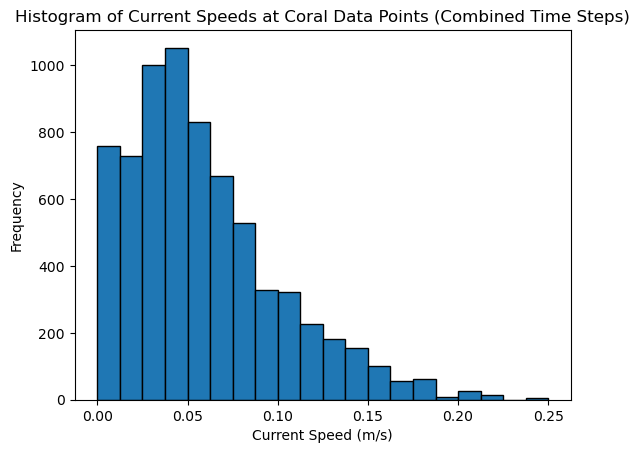

In [ ]:
# Extracting u and v velocity components at t = 0 and depth closest to 250m
u_velocity_var = PhysStates_data.variables['u_velocity']
v_velocity_var = PhysStates_data.variables['v_velocity']

# Using the first 150 time steps
u_velocity = u_velocity_var[:150, layer_index, :, :]
v_velocity = v_velocity_var[:150, layer_index, :, :]

# Calculate the magnitude of the current speed
current_speed = np.sqrt(u_velocity**2 + v_velocity**2)

# Extract current speed at coral data points
coral_current_speeds = []
for time in range(current_speed.shape[0]):
    for x, y in zip(coral_data['x'], coral_data['y']):
        # Ensure the coordinates are within the grid bounds
        if 0 <= x < current_speed.shape[2] and 0 <= y < current_speed.shape[1]:
            speed_value = current_speed[time, int(y), int(x)]
            if not np.ma.is_masked(speed_value):
                coral_current_speeds.append(speed_value)

# Convert list to numpy array for easier manipulation
coral_current_speeds = np.array(coral_current_speeds)

# Flatten the array to combine all time steps
coral_current_speeds_flat = coral_current_speeds.flatten()

# Plot histogram of the combined current speed values
plt.hist(coral_current_speeds_flat, bins=20, edgecolor='black')
plt.xlabel('Current Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Current Speeds at Coral Data Points (Combined Time Steps)')
plt.show()

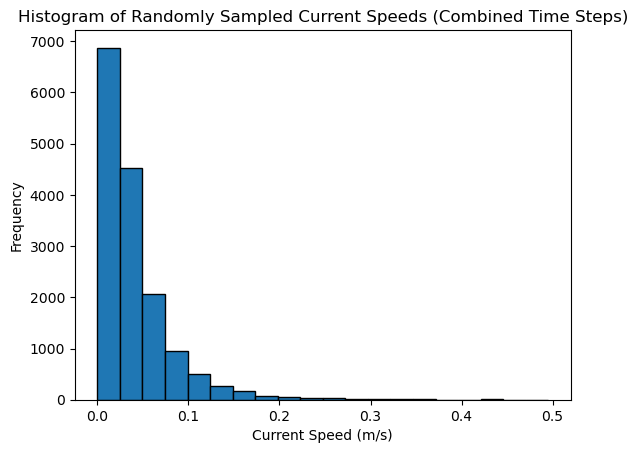

Total data points in coral current speeds histogram: 15600
Total data points in random current speeds histogram: 15600


In [ ]:
# Randomly sample the same number of points as the coral data at each time point
random_current_speeds = []

# Get the valid (non-masked) indices
valid_indices = np.argwhere(~current_speed.mask[0, :, :])

for time in range(current_speed.shape[0]):
    # Randomly select indices from the valid indices
    selected_indices = valid_indices[np.random.choice(valid_indices.shape[0], num_coral_points, replace=False)]
    
    for y_idx, x_idx in selected_indices:
        speed_value = current_speed[time, y_idx, x_idx]
        random_current_speeds.append(speed_value)

# Convert list to numpy array for easier manipulation
random_current_speeds = np.array(random_current_speeds)

# Flatten the array to combine all time steps
random_current_speeds_flat = random_current_speeds.flatten()

# Plot histogram of the combined random current speed values
plt.hist(random_current_speeds_flat, bins=20, edgecolor='black')
plt.xlabel('Current Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Randomly Sampled Current Speeds (Combined Time Steps)')
plt.show()

# Print the total number of data points on each histogram
print(f"Total data points in coral current speeds histogram: {len(coral_current_speeds_flat)}")
print(f"Total data points in random current speeds histogram: {len(random_current_speeds_flat)}")